# Example Notebook: Daily Precipitation Amounts Return Intervals

In this example we examine the daily precipitation distribution during the year 2000 at Corvallis Oregon (Lat: 44.5704; Lon: -123.2844). We'll plot the empirical and a theoretical distribution, calculate return intervals for that year, and estimate the depth of the 5-day storm. Because we are looking at the depth of rainfall on rainy days, we will remove days without rain.

## Load the Data
The first thing we must do is load the data. We will use the data downloaded  from the PRISM website for the daily precipitation at the above coordinates for the year 2000. The file named *PRISM_ppt_tdmean_stable_4km_20000101_20001231_46.7299_-124.0376.csv* must be in the same folder on the BEE Jupyter Hub as this notebook. After including the standard imports, we load the ppt file using the 'genfromtxt' function. We then calculate the mean, standard deviation, and plot the daily values for days when there is percipitation.

P mean: 7.56mm P std: 9.34mm


Text(0, 0.5, 'Precpitiation [mm]')

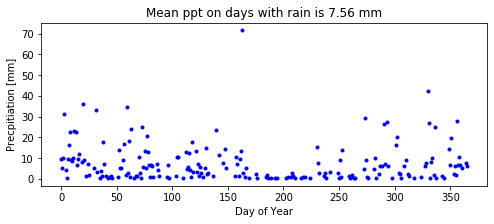

In [1]:
# Import numeric python and the plotting library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the PRISM data for 2000
ppt2000filename = 'PRISM_ppt_tdmean_stable_4km_20000101_20001231_46.7299_-124.0376.csv'
pptDaily = np.genfromtxt(ppt2000filename,delimiter=',',skip_header=11,usecols={1})
pptDailyNoZeros = pptDaily[pptDaily>0]

# Calculat Stats
pptMean = np.mean(pptDailyNoZeros)
pptStd = np.std(pptDailyNoZeros)
print('P mean: %.2fmm'%pptMean,'P std: %.2fmm'%pptStd)

# Plot the data
days = np.arange(0,366)
daysNoZeros = days[pptDaily>0]
plt.figure(1,figsize=(8,3))
plt.plot(daysNoZeros,pptDailyNoZeros,'b.')
plt.title('Mean ppt on days with rain is %.2f mm' % pptMean)
plt.xlabel('Day of Year') ;plt.ylabel('Precpitiation [mm]')


## The Empirical Distrbution
Next we will estimate the 'empirical' distribution of the rainfall. This is the non-exceedance probability, or the probability that a random value $X$ will be less than or equal to $x$. This is calculated by sorting the data, creating an array of the ranks of each data point, and then calculating the CDF value as;

$$ F_{empirical}(x) = \frac{i}{N+1} $$

where $i$ is the rank of the data and $N$ is the total number of data points. We calculate the empirical values, $F(x)$ and plot these with the x-axis in log scale.

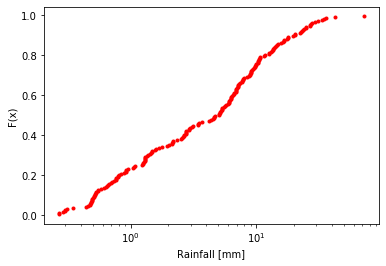

In [2]:
# Calculate the empirical CDF
pptSorted = np.sort(pptDailyNoZeros)
pptRanked = np.arange(len(pptDailyNoZeros))+1
pptEmpiricalCDF = pptRanked/(len(pptDailyNoZeros)+1)

# Plot this CDF
plt.figure(2)
plt.plot(pptSorted,pptEmpiricalCDF,'r.')
plt.xlabel('Rainfall [mm]'); plt.ylabel('F(x)'); plt.xscale('log')

## Interpolated Values
What if we want an estimate of a value between one of our observations? Then we could interpolate between data points. To do this we can used the **np.interp** function in numpy.


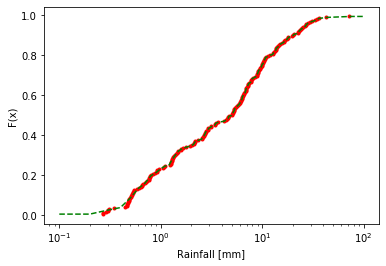

In [3]:
pptValues = np.arange(.1,100,.1)
pptInterpCDF = np.interp(pptValues,pptSorted,pptEmpiricalCDF)
# Plot this CDF
plt.figure(2)
plt.plot(pptSorted,pptEmpiricalCDF,'r.')
plt.plot(pptValues,pptInterpCDF,'g--')
plt.xlabel('Rainfall [mm]'); plt.ylabel('F(x)'); plt.xscale('log')

## Fit a theoretical distirbution (using curve_fit)
Another way to estimate a value using this data is to fit an equation to a set of data points is by using a curve fitting method. It is offten the case that one can assume that the precipitation amount on days when there is rainfall follows an exponential distribution. The cumulative distribution function (CDF) for this is:

$$ F(x) = 1 - e^{-\eta  x } $$

is found in table C.1 of the text, where for this example we'll assume that $\xi$ is zero. This distribution was chosen because it has been found to work well for daily rainfall amounts. we can fit this distribution to the CDF using the *curve_fit* function in the numpy libraray.

[0.15332909] [[5.73630847e-06]]


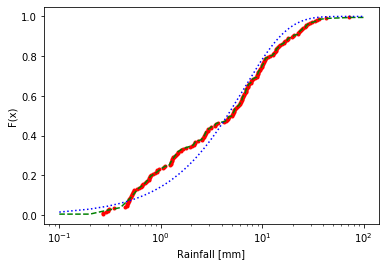

In [4]:
from scipy.optimize import curve_fit
def expCDF(x, n):
    return 1 - np.exp(-x*n)
# Fit the curve
popt, pcov = curve_fit(expCDF, pptSorted, pptEmpiricalCDF)
print(popt, pcov)
pptFitCDF = expCDF(pptValues,popt[0])
# Plot more CDFS
plt.figure(2)
plt.plot(pptSorted,pptEmpiricalCDF,'r.')
plt.plot(pptValues,pptInterpCDF,'g--')
plt.plot(pptValues,pptFitCDF,'b:')
plt.xlabel('Rainfall [mm]'); plt.ylabel('F(x)'); plt.xscale('log')

## Fit a theoretical  distribution (Method of Moments)
The method of moments is a way to choose the free parameters of the distribution such that the moments (mean, standard deviation, etc.) match the observed data. To apply this method, we need to relate the distribution  parameter $\eta$ to the mean $\mu$. From table C.1 in the text wee see that if $\xi$ is zero we have:

$$ \mu = \frac{1}{\eta} $$

where $\mu$ is the mean rainfall depth. This is easily re-arranged to solve for $\eta$. We then add the exponential values to the above plot. Note how well they align. This is called the 'method of moments', because we've fit the parameters based on the moments (i.e. the mean, std, etc.) of the distribution.

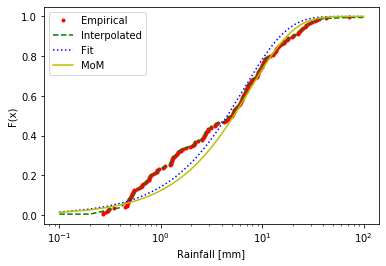

In [5]:
# Calculate the Exponential CDF with the method of moments
eta = 1/pptMean
pptMoMCDF = 1-np.exp(-eta*(pptValues))

# Plot the Empirical and Exponential CDFs
plt.figure(2)
plt.plot(pptSorted,pptEmpiricalCDF,'r.',label='Empirical')
plt.plot(pptValues,pptInterpCDF,'g--',label='Interpolated')
plt.plot(pptValues,pptFitCDF,'b:',label='Fit')
plt.plot(pptValues,pptMoMCDF,'y-',label='MoM')

plt.xlabel('Rainfall [mm]'); plt.ylabel('F(x)'); plt.legend()
plt.xscale('log')

## Return Intervals
We calculate the return interval based on the CDF values as:

$$ RI(x) = \frac{1}{1-F(x)} $$

We then plot return intervals based on the theoretical and empirical distributions. Note, the y-axis is now also changed to a log scale. Finally, we estimate the depth of the 5-day storm. We use the *argmin* command to find the index where the difference is smallest.

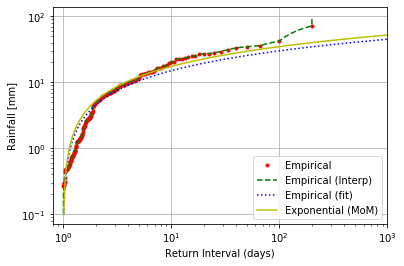

The 5-day storm has a depth of 11.8mm using an interpolated CDF
The 5-day storm has a depth of 10.5mm using a curve_fit exponential CDF
The 5-day storm has a depth of 12.2mm using a MoM fit exponential CDF


In [6]:
# Calculate the Return Intervals based on the CDFs
pptEmpericalRI = 1/(1-pptEmpiricalCDF)
pptInterpRI = 1/(1-pptInterpCDF)
pptFitRI = 1/(1-pptFitCDF)
pptMomRI = 1/(1-pptMoMCDF)

# Plot the Return Intervals
plt.figure(3)
plt.plot(pptEmpericalRI,pptSorted,'r.',label='Empirical')
plt.plot(pptInterpRI,pptValues,'g--',label='Empirical (Interp)')
plt.plot(pptFitRI,pptValues,'b:',label='Empirical (fit)')
plt.plot(pptMomRI,pptValues,'y-',label='Exponential (MoM)')
plt.yscale('log'); plt.xscale('log')  # Change the y axis to log scale
plt.ylabel('Rainfall [mm]'); plt.xlabel('Return Interval (days)');plt.legend()
plt.xlim((0.8,10**3)); plt.grid()
plt.show()

# For a mm day 
pptDay = 5
print('The %d-day storm has a depth of %.1fmm using an interpolated CDF' % (
    pptDay, pptValues[np.argmin((pptInterpRI-pptDay)**2)]))
print('The %d-day storm has a depth of %.1fmm using a curve_fit exponential CDF' % (
    pptDay, pptValues[np.argmin((pptFitRI-pptDay)**2)]))
print('The %d-day storm has a depth of %.1fmm using a MoM fit exponential CDF' % (
    pptDay, pptValues[np.argmin((pptMomRI-pptDay)**2)]))